In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sklearn.datasets
import sklearn.feature_extraction.text
import sklearn.preprocessing
from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import normalize
import scipy.sparse
import vectorizers
import vectorizers.transformers
import seaborn as sns
import warnings
import igraph as ig
from scipy.sparse import vstack
      
warnings.simplefilter("ignore")
sns.set()

import umap
import umap.plot
umap.plot.output_notebook()
from bokeh.plotting import show


Loading BokehJS ...

In [2]:
datadir = '../Data/NCI1/'

## read data from NCI folder
fn_edges = datadir+'DS_A.txt'
fn_graph_id = datadir+'DS_graph_indicator.txt'
fn_graph_label = datadir+'DS_graph_labels.txt'
fn_node_label = datadir+'DS_node_labels.txt'


In [3]:
## read edges, build overall graph
with open(fn_edges) as f:
    E = [tuple(map(int,x.strip().split(','))) for x in f.readlines()]
G = ig.Graph.TupleList(E, directed=True).as_undirected()

## read subgraph node memberships (subgraphs names are 1-based)
with open(fn_graph_id) as f:
    sg_mem = [int(x.strip()) for x in f.readlines()]
    
## some vertices do not appear in any edges
## we add those as isolated nodes for easier processing.
vertices = set(G.vs['name'])
print('number of vertices before:',G.vcount(),'min index:',min(vertices),'max index:',max(vertices))
v = set(np.arange(1,len(sg_mem)+1))
diff = v.difference(vertices)
G.add_vertices(list(diff))
print('number of vertices afteur:',G.vcount(),'min index:',min(vertices),'max index:',max(vertices))

## mapping nodes in order of name
node_idx = list(np.argsort(G.vs['name']))

## assign subgraph
for i in range(len(sg_mem)):
    G.vs[node_idx[i]]['graph'] = sg_mem[i]

## verify with graph label list -- should output 'True'
l = [G.vs[i]['graph'] for i in node_idx]
if l != sg_mem:
    print('something is wrong')

## read and store node labels
with open(fn_node_label) as f:
    l = [int(x.strip()) for x in f.readlines()]
for i in range(len(l)):
    G.vs[node_idx[i]]['label'] = l[i]

## read graph labels
with open(fn_graph_label) as f:
    graph_labels = [int(x.strip()) for x in f.readlines()]


number of vertices before: 122319 min index: 1 max index: 122747
number of vertices afteur: 122747 min index: 1 max index: 122747


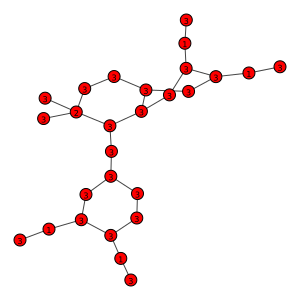

In [4]:
## subgraphs are easy to get
sg_no = 100
sg = G.subgraph(np.where(np.array(G.vs['graph']) == sg_no)[0].tolist())
ig.plot(sg, bbox=(300,300), vertex_size=12, vertex_label_size=8)

In [5]:
G.vs['name'] = [str(i) for i in G.vs['name']]

In [6]:
def get_sg_features(sg):
    F = []
    n = sg.vcount()
    sg.vs['deg'] = sg.degree()
    F.append(sg.vs['deg'])
    F.append(sg.vs['label'])
    for v in sg.vs:
        w = [sg.vs[i]['label'] for i in sg.neighborhood(v)]
        v['ml'] = np.mean(w)
        v['nl'] = len(set(w))    
        w = [sg.vs[i]['deg'] for i in sg.neighborhood(v)]
        v['md'] = np.mean(w)
        v['nd'] = len(set(w))    
        dg = np.zeros(5)
        for d in w:
            dg[min(d,5)-1]+=1
        s = sum(dg)
        v['dg'] = [i/s for i in dg]
    F.append(sg.vs['ml'])
    F.append(sg.vs['nl'])
    F.append(sg.vs['md'])
    F.append(sg.vs['nd'])
    #for i in range(5):
    #    F.append(sg.vs['dg'][i])
    for i in range(7):
        F.append([i/n for i in sg.neighborhood_size(order=i+1)])
    F.append(np.array(sg.betweenness())/sg.vcount()**2)
    F.append(sg.pagerank())
    F.append(sg.transitivity_local_undirected(mode='zero'))
    F = np.array(F).transpose()
    return F

In [7]:
%%time
node_features = []
graphs_vertices = []
for i in list(set(G.vs['graph'])):
    sg = G.subgraph(np.where(np.array(G.vs['graph']) == i)[0].tolist())
    node_features.append(get_sg_features(sg))
    graphs_vertices.append(sg.vs['name'])
node_features = np.array(node_features)
graphs_vertices = np.array(graphs_vertices)

CPU times: user 43.1 s, sys: 94.8 ms, total: 43.2 s
Wall time: 43.2 s


#### decoupled approach

What we need:

* node_features: array (number of graphs) or arrays of size (number of vertices x number of features)
* graph_vertices: array (number of graphs) of lists of vertex names (unique, strings)


In [9]:
vertex_vectors_0 = np.vstack(node_features)
vertex_vectors_0.shape

(122747, 16)

In [10]:
vertex_names = list(np.hstack(graphs_vertices))
vertex_names_dictionary = dict()
for i, v in enumerate(vertex_names):
    vertex_names_dictionary[v] = i    
n_vertices = len(vertex_names_dictionary)

In [11]:
%%time
incidence_vectorizer = vectorizers.NgramVectorizer(
    token_dictionary=vertex_names_dictionary
).fit(graphs_vertices)

incidence_matrix = incidence_vectorizer.transform(graphs_vertices)

CPU times: user 1.98 s, sys: 28 ms, total: 2.01 s
Wall time: 2.03 s


In [12]:
incidence_matrix.shape

(4110, 122747)

In [13]:
%%time
# n_components = vertex_vectors_0.shape[0]
graph_awe_matrix_0 = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    # n_components=n_components,
    random_state=42,
).fit_transform(incidence_matrix, vectors=vertex_vectors_0)

graph_awe_matrix_0.shape

CPU times: user 3.66 s, sys: 241 ms, total: 3.9 s
Wall time: 232 ms


(4110, 16)

In [14]:
g_mapper = umap.UMAP(random_state=42).fit(graph_awe_matrix_0)


In [15]:
p = umap.plot.interactive(
    g_mapper, 
    labels=graph_labels,
    point_size=3, 
    width=800, 
    height=600, 
    theme='fire')
show(p)

In [16]:
node_incidence_matrix = G.get_adjacency_sparse()
node_incidence_matrix.setdiag(1) ## add self to neighbourhoods
node_incidence_matrix

<122747x122747 sparse matrix of type '<class 'numpy.int64'>'
	with 388253 stored elements in Compressed Sparse Row format>

In [17]:
hyperedges_all = [ [str(int(G.vs[x]['name'])) for x in G.neighborhood(v)] for v in range(G.vcount())]


In [18]:
vertex_vectors_norm_0 = normalize(vertex_vectors_0, axis=1, norm='l1')

graph_awe_matrix_norm_0 = vectorizers.ApproximateWassersteinVectorizer(
    normalization_power=0.66,
    
    # n_components=n_components,
    random_state=42,
).fit_transform(incidence_matrix, vectors=vertex_vectors_norm_0)

In [19]:
vertex_awe_vectors = dict()
graph_awe_matrix = dict()
graph_awe_matrix_svd = dict()

In [20]:
number_iteration = 3

In [21]:
vertex_awe_vectors[0] = vertex_vectors_0
graph_awe_matrix[0] = graph_awe_matrix_0

In [22]:
vertex_awe_vectors[0] = normalize(vertex_awe_vectors[0], axis=1, norm='l1')
n_components = vertex_awe_vectors[0].shape[1]
svd = TruncatedSVD(n_components=n_components)

for i in range(1,number_iteration):
    vertex_awe_vectors[i] = vectorizers.ApproximateWassersteinVectorizer(
        normalization_power=0.66,
        random_state=42,
        # n_components=n_components
    ).fit_transform(node_incidence_matrix, vectors=vertex_awe_vectors[i-1])


    vertex_awe_vectors[i] = normalize(vertex_awe_vectors[i], axis=1, norm='l1')

    graph_awe_matrix[i] = vectorizers.ApproximateWassersteinVectorizer(
        random_state=42,
        # n_components=n_components,
        normalization_power=0.66,
    ).fit_transform(incidence_matrix, 
                    vectors=np.hstack([vertex_awe_vectors[i] for j in range(i+1)])
                   )
    
    graph_awe_matrix_svd[i] = svd.fit_transform(graph_awe_matrix[i])
    
    print(f'Interation {i}, shape of vector matrix {vertex_awe_vectors[i].shape}, shape of graph matrix {graph_awe_matrix[i].shape}')
    

Interation 1, shape of vector matrix (122747, 16), shape of graph matrix (4110, 32)
Interation 2, shape of vector matrix (122747, 16), shape of graph matrix (4110, 48)


In [23]:
vector_df = pd.DataFrame()
vector_df['groups'] = np.hstack(np.array([i]*vertex_awe_vectors[i].shape[0]) for i in range(number_iteration))
vector_df['lengths'] = np.hstack(np.linalg.norm(vertex_awe_vectors[i], axis=1, ord=1) for i in range(number_iteration))

In [24]:
import sklearn.model_selection
import sklearn.ensemble
import sklearn.linear_model
import sklearn.neural_network
import sklearn.neighbors

from sklearn.experimental import enable_hist_gradient_boosting

In [25]:
def cross_validate(model, data, labels, n_splits=20, test_ratio=0.1, random_seed=42):
    splitter = sklearn.model_selection.ShuffleSplit(
        n_splits=n_splits, test_size=test_ratio, random_state=random_seed
    )
    result = sklearn.model_selection.cross_val_score(model, data, labels, cv=splitter)
    return result

def cross_validation_dataframe(model, data, labels, feature_sets, n_splits=20, test_ratio=0.1, random_seed=42):
    dfs = []
    for feature_space_name, feature_space in feature_sets.items():
        cv_scores = cross_validate(model, feature_space, labels, n_splits, test_ratio, random_seed)
        feature_df = pd.DataFrame(
            {
                "run" : np.arange(n_splits), 
                "Embedding" : feature_space_name,
                "Model" : model.__repr__().split("(")[0],
                "Accuracy" : cv_scores,
            }
        )
        dfs.append(feature_df)
    return pd.concat(dfs)

In [26]:
from collections import Counter
Counter(graph_labels)

Counter({0: 2053, 1: 2057})

In [27]:
models_norm = [
    sklearn.neighbors.KNeighborsClassifier(metric="cosine", n_neighbors=10, weights="distance"),
    # sklearn.ensemble.HistGradientBoostingClassifier(),
    sklearn.ensemble.RandomForestClassifier(),
    # sklearn.neural_network.MLPClassifier(hidden_layer_sizes=(100, 80, 40))
]
feature_sets_norm = {
    "Wasserstein original": graph_awe_matrix_0,
    "Wasserstein normalized":  graph_awe_matrix_norm_0
}

In [28]:
%%time
results_norm = []
for model in models_norm:
    print(model)
    res = cross_validation_dataframe(
        model, 
        feature_sets_norm,
        graph_labels,
        feature_sets = feature_sets_norm
    )
    results_norm.append(res)

df_norm = pd.concat( results_norm )

KNeighborsClassifier(metric='cosine', n_neighbors=10, weights='distance')
RandomForestClassifier()
CPU times: user 1min 33s, sys: 2.14 s, total: 1min 35s
Wall time: 54.1 s


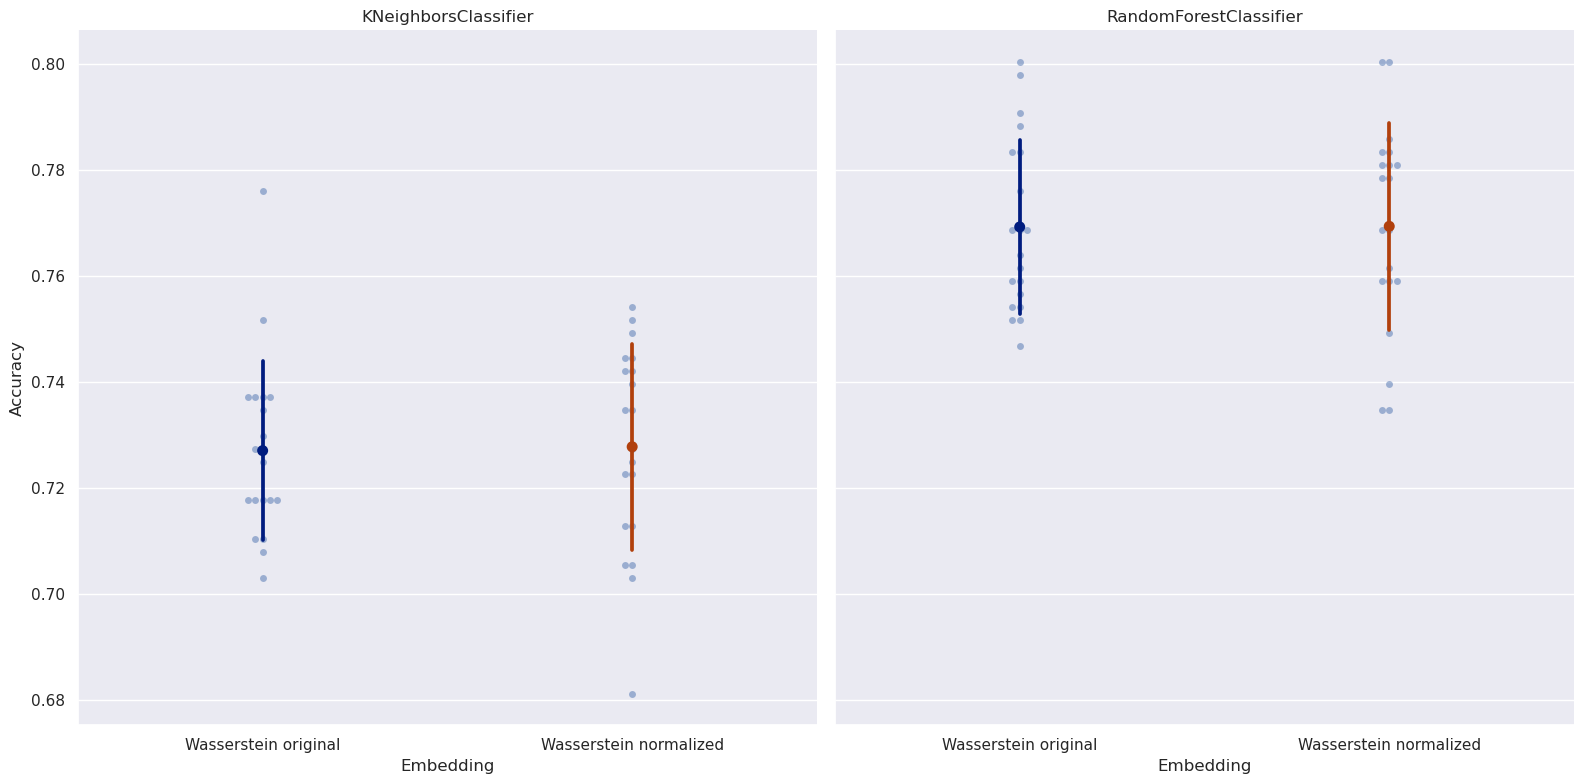

In [29]:
g = sns.catplot(
    kind="swarm", 
    x="Embedding", 
    y="Accuracy", 
    col="Model",
    col_wrap=2,
    data=df_norm, 
    height=8, 
    alpha=0.5,
    zorder=1,
)
g.map_dataframe(
    sns.pointplot, 
    x="Embedding", 
    y="Accuracy", 
    color="Model", 
    data=df_norm, 
    # height=6, 
    # aspect=1.3,
    palette="dark",
    join=False,
    order=[
        "Wasserstein original",
        "Wasserstein normalized"
    ],
    ci="sd",
    # zorder=2,
    scale=0.9,
)
g.set_titles(col_template="{col_name}")
g.set_xticklabels([
        "Wasserstein original",
        "Wasserstein normalized"
    ])
